"""
In this version, models are stacked and some new sad data is added
"""

# Data Processing

In [31]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data
filename = 'data/all_data.csv'
df = pd.read_csv(filename,index_col=0)

filename2 = 'data/sad_new.csv'
df2 = pd.read_csv(filename2,index_col=False)

X1 = df.loc[:,['danceability', 'energy','key','loudness','mode','speechiness',
      'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]
X2 = df2.loc[:,['danceability', 'energy','key','loudness','mode','speechiness',
      'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]
Y1 = df.iloc[:, -1]
Y2 = df2.iloc[:, -1]
X = pd.concat([X1, X2])
Y = pd.concat([Y1, Y2])
Y.column = 'class'

# change the labels with LabelEncoder() and print the mapping relation
label_mapping = {1:'Sad',2:'Healing',4:'joyful'}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
label_mapping_final = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
print('Label mapping:',str([0, 1, 2]), '->',label_mapping_final)

Label mapping: [0, 1, 2] -> ['Sad', 'Healing', 'joyful']


### standardization

In [2]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### review the data: data shape and class distribution

In [3]:
# data shape
print("The shape (n_samples, n_features) is: ", X_std.shape)

# class distribution
from collections import Counter
counter = Counter(Y)
print(counter)

The shape (n_samples, n_features) is:  (14146, 13)
Counter({1: 9629, 2: 4079, 0: 438})


# split training and testing sets

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_std,Y,stratify=Y, test_size=0.2, random_state=1)

# oversampling

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over_sampling_strategy = {0: int(0.3 * len(y_train))}
under_sampling_strategy = {1: int(0.42 * len(y_train)), 2: int(0.28 * len(y_train))}

# define pipeline
over = SMOTE(sampling_strategy=over_sampling_strategy)
under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 4752, 0: 3394, 2: 3168})


# stacking models

In [6]:
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# models
pca = decomposition.PCA(n_components=13)
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=12)
rforest = RandomForestClassifier(criterion='entropy', max_depth=8, 
                               max_features='auto', n_estimators=200)
svm = SVC(C=1000, gamma=0.1, kernel='rbf')
logis = LogisticRegression(solver='lbfgs', max_iter=200)
                                 
models = [('dtree', dtree), 
          ('rforest', rforest),
          ('svm', svm)]
stacking = StackingClassifier(
            estimators=models, 
            final_estimator = logis)
pipe = Pipeline(
            steps=[('pca', pca), 
           ('stacking', stacking)])

# result

In [7]:
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

# print classification report
print(classification_report(y_test, predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.43      0.48      0.45        88
     Healing       0.95      0.97      0.96      1926
      joyful       0.90      0.86      0.88       816

    accuracy                           0.92      2830
   macro avg       0.76      0.77      0.76      2830
weighted avg       0.92      0.92      0.92      2830



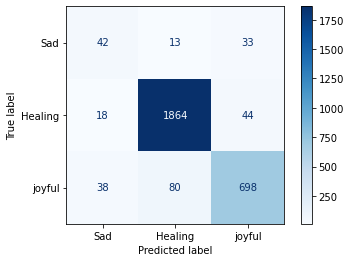

In [8]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
plot_confusion_matrix(pipe, X_test, y_test,cmap=plt.cm.Blues, 
                     display_labels=display_labels)  
plt.show() 